<a href="https://colab.research.google.com/github/tsmanral/Author-Prediction-Using-Deep-Learning-Models/blob/master/POS_Model_for_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D
from keras.layers import Flatten, GlobalAveragePooling1D
from keras.layers import Embedding, TimeDistributed, MaxPooling1D
import keras.utils
from keras.callbacks import ModelCheckpoint  


Using TensorFlow backend.


In [0]:
## extra imports to set GPU options
import tensorflow as tf
from keras import backend as k
 
###################################
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.8
 
# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))
###################################

In [0]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))


TensorFlow Version: 1.6.0
Default GPU Device: /device:GPU:0


In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data_pos')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
file_list = drive.ListFile(
    {'q': "'1OIo2AFE5433kfj9QGpGJVYERoWcmXVzB' in parents"}).GetList()

data = []
for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)
  with open(fname, 'r', encoding = "ISO-8859-1") as file:
    data.append([f['title'].split('-')[0], file.read()])

title: George Gissing - 2.txt, id: 1lCMmjhdF4MlD8mWVVhMgdUDv7Hki3_-d
downloading to /content/data_pos/George Gissing - 2.txt
title: Humphrey Ward - 13.txt, id: 1yP2cZU3-djw5epRNhUyRf3Cprc-adBtq
downloading to /content/data_pos/Humphrey Ward - 13.txt
title: George Gissing - 15.txt, id: 16Qap744WSUYEpbPIYRfIWnxAkB5rnXiL
downloading to /content/data_pos/George Gissing - 15.txt
title: Arthur Conan Doyle - 11.txt, id: 1HB_DcPLPafswhFbgjRYImH8GfBvghplJ
downloading to /content/data_pos/Arthur Conan Doyle - 11.txt
title: Humphrey Ward - 10.txt, id: 1Tiqv8_lApsZPbgANKnGH_NmXotwmNx4G
downloading to /content/data_pos/Humphrey Ward - 10.txt
title: Arthur Conan Doyle - 10.txt, id: 1nRXK4FBhXvehImie22HvK4qG5FISiHFu
downloading to /content/data_pos/Arthur Conan Doyle - 10.txt
title: Arthur Conan Doyle - 7.txt, id: 1nz4_r-CvQZwKg91cnAvsHQE7UvA4eWoj
downloading to /content/data_pos/Arthur Conan Doyle - 7.txt
title: Henry Rider Haggard - 7.txt, id: 1vfyVPEJUqVHhyQd-4rJ4qLCfxoAY5kDO
downloading to /conte

title: Gilbert Parker - 13.txt, id: 1O-O3f6NFXYFZYy9f5HkIVKIEqNH9sgy_
downloading to /content/data_pos/Gilbert Parker - 13.txt
title: Arthur Conan Doyle - 16.txt, id: 1WXzRRGG2pt9QC3a1oan3Wg-Hfe3QJBLi
downloading to /content/data_pos/Arthur Conan Doyle - 16.txt
title: Henry Rider Haggard - 12.txt, id: 1oDjEYDQjP7KdxO2VpzU08m5kJXdPOTK4
downloading to /content/data_pos/Henry Rider Haggard - 12.txt
title: Henry Rider Haggard - 25.txt, id: 1BrlRls7K1mCOdefL5Ih0Cr3jFpfxGqbv
downloading to /content/data_pos/Henry Rider Haggard - 25.txt
title: Arthur Conan Doyle - 12.txt, id: 1PSFBrdrggGe1b_1Z2O5WdnlHkdFSFOo_
downloading to /content/data_pos/Arthur Conan Doyle - 12.txt
title: Arthur Conan Doyle - 4.txt, id: 1p-XRhYDQCdccoYflkHuAdXkZVOwjpfdm
downloading to /content/data_pos/Arthur Conan Doyle - 4.txt
title: Humphrey Ward - 8.txt, id: 1E3UCDg2V70_N1nxpFSsrAiyBVziTMRdl
downloading to /content/data_pos/Humphrey Ward - 8.txt
title: Gilbert Parker - 7.txt, id: 1I2AgUyOdTnZ76rTHjsQRUmANa5P_5pqH
down

title: Gilbert Parker - 5.txt, id: 1atkDIkWgZN0xOYrLc0CAcmtS5x1kJqD0
downloading to /content/data_pos/Gilbert Parker - 5.txt
title: Henry Rider Haggard - 9.txt, id: 1IDmhDWbLnsoPrRkQwdrejXAm3WL4Z7m8
downloading to /content/data_pos/Henry Rider Haggard - 9.txt
title: Humphrey Ward - 14.txt, id: 1CzoKzHf8dCmvKo_x5Bd7cDxpUaINqowR
downloading to /content/data_pos/Humphrey Ward - 14.txt
title: Gilbert Parker - 12.txt, id: 1n_S6h-ax02aDj8sGXNLGqrHRtHhCR8eh
downloading to /content/data_pos/Gilbert Parker - 12.txt
title: Arthur Conan Doyle - 5.txt, id: 1UVH3T5AUm6Xyd7W4q-H07H1gOGkD17-g
downloading to /content/data_pos/Arthur Conan Doyle - 5.txt
title: Gilbert Parker - 6.txt, id: 1smgTQyEwOyvyB1bxp2YIF03urzWAkr3A
downloading to /content/data_pos/Gilbert Parker - 6.txt
title: Humphrey Ward - 15.txt, id: 1mgS1p_sVn70GjneAqQryC43fUphPZ1gC
downloading to /content/data_pos/Humphrey Ward - 15.txt
title: Henry Rider Haggard - 19.txt, id: 17kGjYBSqYp4RwYY8HIL3-pphflfxxKbw
downloading to /content/data_p

In [0]:
X = []
for _,c in data:
    X.append(c.lower())
    
Y = []
for i,_ in data:
    Y.append(i.lower())

X1 = []
Y_data1 = []

for text in X:
  c = text.strip().split()
  X1.append(c)

print(len(X))
X_data1 = []
count = 0
for i in X1:
  m=0
  n=1000
  times = len(i)//1000
  for j in range(times):
    X_data1.append(i[m:n])
    m = m + 1000
    n = n + 1000
    Y_data1.append(Y[count]) 
  X_data1.append(i[m:len(i)+1])
  Y_data1.append(Y[count])
  count = count + 1 



98


In [0]:
temp_list = []
for i in range(len(X_data1)):
  temp_list.append([X_data1[i], Y_data1[i]])
print(len(temp_list))
print(temp_list[0][1])

import random

random.shuffle(temp_list)
print(len(temp_list))
print(temp_list[0][1])

X_data = []
Y_data = []
for i in range(len(temp_list)):
  X_data.append(temp_list[i][0])
  Y_data.append(temp_list[i][1])
print(len(X_data), len(Y_data))
print(X_data[0], Y_data[0])

11163
george gissing 
11163
henry rider haggard 
11163 11163
['vbd', 'rb', 'in', 'nn', 'cc', 'jj', 'fw', 'fw', 'vbz', 'dt', 'nn', 'vbd', 'nnp', 'nnp', 'nnp', 'fw', 'fw', 'in', 'dt', 'jj', 'nn', 'in', 'nn', 'prp', 'fw', 'fw', 'fw', 'fw', 'nnp', 'vbp', 'nnp', 'cc', 'nnp', 'wp', 'vbp', 'prp$', 'nn', 'rb', 'jj', 'in', 'fw', 'fw', 'vbp', 'rb', 'rb', 'in', 'nn', 'prp', 'vbp', 'dt', 'jj', 'nn', 'to', 'nn', 'cc', 'in', 'rb', 'prp', 'vbd', 'wp', 'dt', 'nn', 'prp$', 'nn', 'nn', 'cc', 'vbz', 'vbn', 'in', 'dt', 'jj', 'cd', 'nn', 'prp', 'md', 'vb', 'prp', 'vbp', 'nnp', 'nnp', 'prp', 'vbp', 'rb', 'vbn', 'nn', 'cc', 'md', 'rb', 'vb', 'nn', 'nn', 'vbz', 'jj', 'in', 'prp$', 'fw', 'fw', 'prp$', 'nn', 'vbz', 'in', 'cd', 'cd', 'dt', 'nn', 'cc', 'cd', 'in', 'prp', 'md', 'fw', 'fw', 'fw', 'cc', 'prp', 'vbp', 'fw', 'fw', 'in', 'prp$', 'nn', 'vbz', 'nn', 'nn', 'nn', 'nn', 'prp', 'vbp', 'dt', 'jj', 'nn', 'dt', 'jj', 'nnp', 'cc', 'rb', 'prp', 'md', 'vb', 'rb', 'to', 'vb', 'prp$', 'nn', 'cc', 'vb', 'prp$', 'nn',

In [0]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Converting Output values to One Hot Vector
print("Converting to One hot vector(training set)...")
Y_data = np.array(Y_data)
#print(train_values)

label_encoder = LabelEncoder()
train_integer_encoded = label_encoder.fit_transform(Y_data)
print(train_integer_encoded)


Converting to One hot vector(training set)...
[3 1 4 ... 0 4 3]


In [0]:
train_onehot_encoded = keras.utils.to_categorical(train_integer_encoded)
print(train_onehot_encoded[2824,:])

[0. 1. 0. 0. 0.]


In [0]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(X_data)
vocab_size = len(t.word_index) + 1
print(vocab_size)

35


In [0]:
# integer encode the documents
encoded_docs = t.texts_to_sequences(X_data)
print(encoded_docs[0])

[5, 8, 2, 1, 7, 4, 10, 10, 19, 3, 1, 5, 9, 9, 9, 10, 10, 2, 3, 4, 1, 2, 1, 6, 10, 10, 10, 10, 9, 16, 9, 7, 9, 22, 16, 12, 1, 8, 4, 2, 10, 10, 16, 8, 8, 2, 1, 6, 16, 3, 4, 1, 15, 1, 7, 2, 8, 6, 5, 22, 3, 1, 12, 1, 1, 7, 19, 14, 2, 3, 4, 21, 1, 6, 18, 13, 6, 16, 9, 9, 6, 16, 8, 14, 1, 7, 18, 8, 13, 1, 1, 19, 4, 2, 12, 10, 10, 12, 1, 19, 2, 21, 21, 3, 1, 7, 21, 2, 6, 18, 10, 10, 10, 7, 6, 16, 10, 10, 2, 12, 1, 19, 1, 1, 1, 1, 6, 16, 3, 4, 1, 3, 4, 9, 7, 8, 6, 18, 13, 8, 15, 13, 12, 1, 7, 13, 12, 1, 8, 7, 8, 2, 3, 4, 11, 2, 6, 16, 2, 6, 19, 3, 1, 2, 1, 8, 14, 1, 7, 19, 6, 8, 4, 15, 3, 9, 2, 9, 17, 8, 2, 3, 1, 15, 13, 2, 3, 4, 11, 3, 4, 1, 15, 12, 1, 19, 3, 1, 14, 2, 3, 1, 2, 1, 2, 3, 1, 2, 3, 1, 2, 1, 2, 1, 3, 11, 2, 6, 16, 6, 18, 13, 8, 33, 33, 33, 7, 8, 6, 18, 13, 2, 12, 1, 20, 18, 6, 8, 16, 4, 15, 4, 2, 16, 13, 7, 13, 9, 9, 3, 22, 16, 15, 13, 3, 1, 2, 3, 9, 9, 9, 7, 2, 3, 4, 1, 22, 5, 2, 7, 14, 12, 1, 13, 3, 1, 17, 15, 12, 1, 3, 1, 5, 3, 9, 1, 2, 1, 7, 3, 1, 3, 1, 2, 3, 9, 1, 6, 5, 3, 4

In [0]:
# pad documents to a max length of 10000 words
max_length = 1000
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

[[ 5  8  2 ... 10 10 10]
 [ 6  5 12 ...  1  5 14]
 [ 3  4  1 ...  3  2  3]
 ...
 [16  8 14 ...  4 15  8]
 [ 1  2 12 ...  3  1  7]
 [ 8  8  7 ...  1 17  2]]


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
file_list = drive.ListFile(
    {'q': "'1ogZLyJ5GTI8a0o8HPac8zTtm96SzCv-k' in parents"}).GetList()
print(file_list[0]['title'], file_list[0]['id'] )
fname = os.path.join(local_download_path, file_list[0]['title'])
f_ = drive.CreateFile({'id': file_list[0]['id']})
f_.GetContentFile(fname)


# load the whole embedding into memory
embeddings_index = dict()
f = open(fname)
for line in f:
	values = line.split()
	word = values[0]
	coefs = asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

glove.6B.100d.txt 17BmrNJa4oJDNg3KZ6u2Ww0ETQYklOJJ7
Loaded 400000 word vectors.


In [0]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 100))
for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

(35, 100)


In [0]:
print(padded_docs.shape)
doc_train = np.array(padded_docs[0:8000,:])
print(doc_train.shape)
doc_test = np.array(padded_docs[8000:,:])
print(doc_test.shape)

onehot_train = np.array(train_onehot_encoded[0:8000,:])
print(onehot_train.shape)
onehot_test = np.array(train_onehot_encoded[8000:,:])
print(onehot_test.shape)

(11163, 1000)
(8000, 1000)
(3163, 1000)
(8000, 5)
(3163, 5)


In [0]:
# define model
model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=1000, trainable=False)
model.add(e)
model.add(Conv1D(16, 3, border_mode='valid'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(32, 3, border_mode='valid'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, 3, border_mode='valid'))
model.add(MaxPooling1D(pool_size=2))

model.add(GlobalAveragePooling1D())
model.add(Dropout(0.3))

model.add(Dense(3000, activation='relu', kernel_initializer='glorot_uniform'))
model.add(Dropout(0.3))

#model.add(Dense(30000, activation='relu'))
#model.add(Dropout(0.6))

model.add(Dense(5, activation='softmax'))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(16, 3, padding="valid")`
  after removing the cwd from sys.path.


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(32, 3, padding="valid")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, 3, padding="valid")`
  


In [0]:
# compile the model
num_of_epochs = 500
batchsize = 2000
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [0]:
# summarize the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         3500      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 998, 16)           4816      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 499, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 497, 32)           1568      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 248, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 246, 64)           6208      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 123, 64)           0         
__________

In [0]:
checkpointer = ModelCheckpoint(filepath='/content/weights.best.CNN_pos.hdf5', 
                               verbose=1, save_best_only=True)

In [0]:
# fit the model
history = model.fit(doc_train, onehot_train, epochs=num_of_epochs, verbose=1, batch_size=batchsize, callbacks=[checkpointer], validation_split=0.2)

Train on 6400 samples, validate on 1600 samples
Epoch 1/500
6400/6400 [==============================] - 3s 438us/step - loss: 1.6929 - categorical_accuracy: 0.2341 - val_loss: 1.5515 - val_categorical_accuracy: 0.2875

Epoch 00001: val_loss improved from inf to 1.55151, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 2/500
6400/6400 [==============================] - 1s 153us/step - loss: 1.5689 - categorical_accuracy: 0.2531 - val_loss: 1.5142 - val_categorical_accuracy: 0.3669

Epoch 00002: val_loss improved from 1.55151 to 1.51420, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 3/500
6400/6400 [==============================] - 1s 153us/step - loss: 1.5336 - categorical_accuracy: 0.3423 - val_loss: 1.5173 - val_categorical_accuracy: 0.2406

Epoch 00003: val_loss did not improve
Epoch 4/500
6400/6400 [==============================] - 1s 154us/step - loss: 1.4968 - categorical_accuracy: 0.3480 - val_loss: 1.4036 - val_categorical_accuracy: 0.4400

Epoch 00004: val

6400/6400 [==============================] - 1s 152us/step - loss: 1.1808 - categorical_accuracy: 0.4995 - val_loss: 1.1882 - val_categorical_accuracy: 0.5181

Epoch 00013: val_loss did not improve
Epoch 14/500
6400/6400 [==============================] - 1s 154us/step - loss: 1.2291 - categorical_accuracy: 0.4798 - val_loss: 1.1860 - val_categorical_accuracy: 0.5238

Epoch 00014: val_loss did not improve
Epoch 15/500
6400/6400 [==============================] - 1s 157us/step - loss: 1.0934 - categorical_accuracy: 0.5948 - val_loss: 1.1281 - val_categorical_accuracy: 0.4756

Epoch 00015: val_loss improved from 1.13008 to 1.12805, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 16/500
6400/6400 [==============================] - 1s 153us/step - loss: 1.1860 - categorical_accuracy: 0.5025 - val_loss: 1.0012 - val_categorical_accuracy: 0.6087

Epoch 00016: val_loss improved from 1.12805 to 1.00122, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 17/500
6400/6400 [=======


Epoch 00025: val_loss did not improve
Epoch 26/500
6400/6400 [==============================] - 1s 154us/step - loss: 1.2110 - categorical_accuracy: 0.5175 - val_loss: 0.8146 - val_categorical_accuracy: 0.7044

Epoch 00026: val_loss did not improve
Epoch 27/500
6400/6400 [==============================] - 1s 154us/step - loss: 0.7771 - categorical_accuracy: 0.7167 - val_loss: 0.6919 - val_categorical_accuracy: 0.7575

Epoch 00027: val_loss improved from 0.73246 to 0.69190, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 28/500
6400/6400 [==============================] - 1s 153us/step - loss: 1.0344 - categorical_accuracy: 0.6198 - val_loss: 0.6750 - val_categorical_accuracy: 0.7912

Epoch 00028: val_loss improved from 0.69190 to 0.67500, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 29/500
6400/6400 [==============================] - 1s 154us/step - loss: 0.7594 - categorical_accuracy: 0.7184 - val_loss: 0.9500 - val_categorical_accuracy: 0.5938

Epoch 00029: val_

6400/6400 [==============================] - 1s 156us/step - loss: 0.6683 - categorical_accuracy: 0.7433 - val_loss: 0.5085 - val_categorical_accuracy: 0.8706

Epoch 00038: val_loss improved from 0.65494 to 0.50845, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 39/500
6400/6400 [==============================] - 1s 154us/step - loss: 0.6150 - categorical_accuracy: 0.7886 - val_loss: 1.3465 - val_categorical_accuracy: 0.5425

Epoch 00039: val_loss did not improve
Epoch 40/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.9180 - categorical_accuracy: 0.6772 - val_loss: 0.5421 - val_categorical_accuracy: 0.7869

Epoch 00040: val_loss did not improve
Epoch 41/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.6324 - categorical_accuracy: 0.7587 - val_loss: 0.6896 - val_categorical_accuracy: 0.6950

Epoch 00041: val_loss did not improve
Epoch 42/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.6834 - categorical

6400/6400 [==============================] - 1s 155us/step - loss: 0.7885 - categorical_accuracy: 0.6975 - val_loss: 0.4589 - val_categorical_accuracy: 0.8619

Epoch 00050: val_loss did not improve
Epoch 51/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.4329 - categorical_accuracy: 0.8703 - val_loss: 0.4085 - val_categorical_accuracy: 0.8850

Epoch 00051: val_loss improved from 0.44474 to 0.40845, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 52/500
6400/6400 [==============================] - 1s 153us/step - loss: 0.6458 - categorical_accuracy: 0.7470 - val_loss: 0.9580 - val_categorical_accuracy: 0.6325

Epoch 00052: val_loss did not improve
Epoch 53/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.7848 - categorical_accuracy: 0.7117 - val_loss: 0.4911 - val_categorical_accuracy: 0.7944

Epoch 00053: val_loss did not improve
Epoch 54/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.5260 - categorical

6400/6400 [==============================] - 1s 155us/step - loss: 0.4576 - categorical_accuracy: 0.8419 - val_loss: 0.3486 - val_categorical_accuracy: 0.9194

Epoch 00062: val_loss improved from 0.37748 to 0.34861, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 63/500
6400/6400 [==============================] - 1s 154us/step - loss: 0.4449 - categorical_accuracy: 0.8491 - val_loss: 0.9598 - val_categorical_accuracy: 0.6388

Epoch 00063: val_loss did not improve
Epoch 64/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.7921 - categorical_accuracy: 0.6848 - val_loss: 0.3230 - val_categorical_accuracy: 0.9225

Epoch 00064: val_loss improved from 0.34861 to 0.32303, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 65/500
6400/6400 [==============================] - 1s 154us/step - loss: 0.3264 - categorical_accuracy: 0.9097 - val_loss: 0.3454 - val_categorical_accuracy: 0.9019

Epoch 00065: val_loss did not improve
Epoch 66/500
6400/6400 [=======

6400/6400 [==============================] - 1s 156us/step - loss: 0.8384 - categorical_accuracy: 0.6872 - val_loss: 0.6704 - val_categorical_accuracy: 0.7269

Epoch 00074: val_loss did not improve
Epoch 75/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.5106 - categorical_accuracy: 0.7977 - val_loss: 0.2744 - val_categorical_accuracy: 0.9269

Epoch 00075: val_loss did not improve
Epoch 76/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.2938 - categorical_accuracy: 0.9083 - val_loss: 0.2880 - val_categorical_accuracy: 0.9231

Epoch 00076: val_loss did not improve
Epoch 77/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.3677 - categorical_accuracy: 0.8678 - val_loss: 0.5631 - val_categorical_accuracy: 0.7894

Epoch 00077: val_loss did not improve
Epoch 78/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.6280 - categorical_accuracy: 0.7523 - val_loss: 0.5599 - val_categorical_accuracy: 0.74

6400/6400 [==============================] - 1s 155us/step - loss: 0.5402 - categorical_accuracy: 0.7923 - val_loss: 0.6423 - val_categorical_accuracy: 0.7306

Epoch 00087: val_loss did not improve
Epoch 88/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.5152 - categorical_accuracy: 0.8044 - val_loss: 0.1954 - val_categorical_accuracy: 0.9644

Epoch 00088: val_loss improved from 0.23152 to 0.19540, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 89/500
6400/6400 [==============================] - 1s 154us/step - loss: 0.2113 - categorical_accuracy: 0.9456 - val_loss: 0.1856 - val_categorical_accuracy: 0.9531

Epoch 00089: val_loss improved from 0.19540 to 0.18556, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 90/500
6400/6400 [==============================] - 1s 154us/step - loss: 0.2141 - categorical_accuracy: 0.9441 - val_loss: 0.2752 - val_categorical_accuracy: 0.9075

Epoch 00090: val_loss did not improve
Epoch 91/500
6400/6400 [=======


Epoch 00099: val_loss did not improve
Epoch 100/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.5797 - categorical_accuracy: 0.7800 - val_loss: 0.4271 - val_categorical_accuracy: 0.8406

Epoch 00100: val_loss did not improve
Epoch 101/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.3762 - categorical_accuracy: 0.8623 - val_loss: 0.1913 - val_categorical_accuracy: 0.9494

Epoch 00101: val_loss did not improve
Epoch 102/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.1919 - categorical_accuracy: 0.9469 - val_loss: 0.1726 - val_categorical_accuracy: 0.9581

Epoch 00102: val_loss did not improve
Epoch 103/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.2125 - categorical_accuracy: 0.9402 - val_loss: 0.3904 - val_categorical_accuracy: 0.8681

Epoch 00103: val_loss did not improve
Epoch 104/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.5828 - categorical_accuracy: 0

6400/6400 [==============================] - 1s 155us/step - loss: 0.2113 - categorical_accuracy: 0.9339 - val_loss: 0.1774 - val_categorical_accuracy: 0.9488

Epoch 00113: val_loss did not improve
Epoch 114/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.1954 - categorical_accuracy: 0.9441 - val_loss: 0.6687 - val_categorical_accuracy: 0.7694

Epoch 00114: val_loss did not improve
Epoch 115/500
6400/6400 [==============================] - 1s 157us/step - loss: 1.2302 - categorical_accuracy: 0.6386 - val_loss: 0.4040 - val_categorical_accuracy: 0.8319

Epoch 00115: val_loss did not improve
Epoch 116/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.2512 - categorical_accuracy: 0.9137 - val_loss: 0.1185 - val_categorical_accuracy: 0.9737

Epoch 00116: val_loss improved from 0.12681 to 0.11852, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 117/500
6400/6400 [==============================] - 1s 154us/step - loss: 0.1318 - categor

6400/6400 [==============================] - 1s 156us/step - loss: 0.9837 - categorical_accuracy: 0.7283 - val_loss: 0.4193 - val_categorical_accuracy: 0.8556

Epoch 00126: val_loss did not improve
Epoch 127/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.4304 - categorical_accuracy: 0.8317 - val_loss: 0.3036 - val_categorical_accuracy: 0.8844

Epoch 00127: val_loss did not improve
Epoch 128/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.2132 - categorical_accuracy: 0.9286 - val_loss: 0.0910 - val_categorical_accuracy: 0.9850

Epoch 00128: val_loss improved from 0.10520 to 0.09104, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 129/500
6400/6400 [==============================] - 1s 154us/step - loss: 0.0999 - categorical_accuracy: 0.9797 - val_loss: 0.0869 - val_categorical_accuracy: 0.9850

Epoch 00129: val_loss improved from 0.09104 to 0.08694, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 130/500
6400/6400 [===


Epoch 00138: val_loss did not improve
Epoch 139/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.0964 - categorical_accuracy: 0.9788 - val_loss: 0.0806 - val_categorical_accuracy: 0.9862

Epoch 00139: val_loss improved from 0.08166 to 0.08059, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 140/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.0908 - categorical_accuracy: 0.9811 - val_loss: 0.0753 - val_categorical_accuracy: 0.9875

Epoch 00140: val_loss improved from 0.08059 to 0.07532, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 141/500
6400/6400 [==============================] - 1s 153us/step - loss: 0.0825 - categorical_accuracy: 0.9847 - val_loss: 0.0723 - val_categorical_accuracy: 0.9869

Epoch 00141: val_loss improved from 0.07532 to 0.07226, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 142/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.1101 - categorical_accuracy: 0.9702

6400/6400 [==============================] - 1s 156us/step - loss: 0.3571 - categorical_accuracy: 0.8878 - val_loss: 0.0717 - val_categorical_accuracy: 0.9850

Epoch 00151: val_loss did not improve
Epoch 152/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.0808 - categorical_accuracy: 0.9830 - val_loss: 0.0672 - val_categorical_accuracy: 0.9875

Epoch 00152: val_loss did not improve
Epoch 153/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.0766 - categorical_accuracy: 0.9841 - val_loss: 0.0639 - val_categorical_accuracy: 0.9881

Epoch 00153: val_loss improved from 0.06471 to 0.06392, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 154/500
6400/6400 [==============================] - 1s 154us/step - loss: 0.0726 - categorical_accuracy: 0.9866 - val_loss: 0.0610 - val_categorical_accuracy: 0.9894

Epoch 00154: val_loss improved from 0.06392 to 0.06101, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 155/500
6400/6400 [===


Epoch 00163: val_loss did not improve
Epoch 164/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.0666 - categorical_accuracy: 0.9858 - val_loss: 0.3870 - val_categorical_accuracy: 0.8519

Epoch 00164: val_loss did not improve
Epoch 165/500
6400/6400 [==============================] - 1s 156us/step - loss: 1.5251 - categorical_accuracy: 0.6289 - val_loss: 0.4446 - val_categorical_accuracy: 0.8369

Epoch 00165: val_loss did not improve
Epoch 166/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.2260 - categorical_accuracy: 0.9187 - val_loss: 0.0614 - val_categorical_accuracy: 0.9881

Epoch 00166: val_loss did not improve
Epoch 167/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.0695 - categorical_accuracy: 0.9852 - val_loss: 0.0538 - val_categorical_accuracy: 0.9906

Epoch 00167: val_loss did not improve
Epoch 168/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.0617 - categorical_accuracy: 0

6400/6400 [==============================] - 1s 156us/step - loss: 0.0503 - categorical_accuracy: 0.9909 - val_loss: 0.0512 - val_categorical_accuracy: 0.9875

Epoch 00177: val_loss did not improve
Epoch 178/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.0566 - categorical_accuracy: 0.9875 - val_loss: 0.0402 - val_categorical_accuracy: 0.9906

Epoch 00178: val_loss improved from 0.04499 to 0.04016, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 179/500
6400/6400 [==============================] - 1s 154us/step - loss: 0.0488 - categorical_accuracy: 0.9891 - val_loss: 0.0571 - val_categorical_accuracy: 0.9850

Epoch 00179: val_loss did not improve
Epoch 180/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.7091 - categorical_accuracy: 0.8327 - val_loss: 2.2645 - val_categorical_accuracy: 0.5169

Epoch 00180: val_loss did not improve
Epoch 181/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.7864 - categor


Epoch 00189: val_loss did not improve
Epoch 190/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.0542 - categorical_accuracy: 0.9856 - val_loss: 0.0385 - val_categorical_accuracy: 0.9919

Epoch 00190: val_loss did not improve
Epoch 191/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.0474 - categorical_accuracy: 0.9908 - val_loss: 0.0367 - val_categorical_accuracy: 0.9919

Epoch 00191: val_loss did not improve
Epoch 192/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.0421 - categorical_accuracy: 0.9919 - val_loss: 0.0368 - val_categorical_accuracy: 0.9912

Epoch 00192: val_loss did not improve
Epoch 193/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.0422 - categorical_accuracy: 0.9906 - val_loss: 0.0359 - val_categorical_accuracy: 0.9906

Epoch 00193: val_loss improved from 0.03599 to 0.03590, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 194/500
6400/6400 [===================


Epoch 00202: val_loss did not improve
Epoch 203/500
6400/6400 [==============================] - 1s 154us/step - loss: 0.0375 - categorical_accuracy: 0.9909 - val_loss: 0.0338 - val_categorical_accuracy: 0.9906

Epoch 00203: val_loss did not improve
Epoch 204/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.0402 - categorical_accuracy: 0.9905 - val_loss: 0.0774 - val_categorical_accuracy: 0.9744

Epoch 00204: val_loss did not improve
Epoch 205/500
6400/6400 [==============================] - 1s 154us/step - loss: 1.4549 - categorical_accuracy: 0.7122 - val_loss: 0.6754 - val_categorical_accuracy: 0.7456

Epoch 00205: val_loss did not improve
Epoch 206/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.2938 - categorical_accuracy: 0.8984 - val_loss: 0.0338 - val_categorical_accuracy: 0.9919

Epoch 00206: val_loss did not improve
Epoch 207/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.0438 - categorical_accuracy: 0


Epoch 00215: val_loss did not improve
Epoch 216/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.0444 - categorical_accuracy: 0.9906 - val_loss: 0.0301 - val_categorical_accuracy: 0.9919

Epoch 00216: val_loss did not improve
Epoch 217/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.0375 - categorical_accuracy: 0.9925 - val_loss: 0.0278 - val_categorical_accuracy: 0.9919

Epoch 00217: val_loss did not improve
Epoch 218/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.0358 - categorical_accuracy: 0.9925 - val_loss: 0.0267 - val_categorical_accuracy: 0.9925

Epoch 00218: val_loss did not improve
Epoch 219/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.0344 - categorical_accuracy: 0.9925 - val_loss: 0.0257 - val_categorical_accuracy: 0.9925

Epoch 00219: val_loss improved from 0.02637 to 0.02570, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 220/500
6400/6400 [===================

6400/6400 [==============================] - 1s 155us/step - loss: 0.0314 - categorical_accuracy: 0.9937 - val_loss: 0.0266 - val_categorical_accuracy: 0.9925

Epoch 00228: val_loss did not improve
Epoch 229/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.0305 - categorical_accuracy: 0.9941 - val_loss: 0.0220 - val_categorical_accuracy: 0.9925

Epoch 00229: val_loss improved from 0.02427 to 0.02196, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 230/500
6400/6400 [==============================] - 1s 154us/step - loss: 0.0294 - categorical_accuracy: 0.9933 - val_loss: 0.0225 - val_categorical_accuracy: 0.9925

Epoch 00230: val_loss did not improve
Epoch 231/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.0275 - categorical_accuracy: 0.9939 - val_loss: 0.0201 - val_categorical_accuracy: 0.9962

Epoch 00231: val_loss improved from 0.02196 to 0.02014, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 232/500
6400/6400 [===

6400/6400 [==============================] - 1s 157us/step - loss: 0.0221 - categorical_accuracy: 0.9956 - val_loss: 0.0188 - val_categorical_accuracy: 0.9931

Epoch 00240: val_loss did not improve
Epoch 241/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.0218 - categorical_accuracy: 0.9967 - val_loss: 0.0204 - val_categorical_accuracy: 0.9931

Epoch 00241: val_loss did not improve
Epoch 242/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.3395 - categorical_accuracy: 0.9334 - val_loss: 0.4409 - val_categorical_accuracy: 0.8625

Epoch 00242: val_loss did not improve
Epoch 243/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.5687 - categorical_accuracy: 0.8272 - val_loss: 0.5251 - val_categorical_accuracy: 0.8012

Epoch 00243: val_loss did not improve
Epoch 244/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.2062 - categorical_accuracy: 0.9306 - val_loss: 0.0222 - val_categorical_accuracy: 

6400/6400 [==============================] - 1s 156us/step - loss: 0.1359 - categorical_accuracy: 0.9527 - val_loss: 0.0161 - val_categorical_accuracy: 0.9981

Epoch 00253: val_loss did not improve
Epoch 254/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.0224 - categorical_accuracy: 0.9959 - val_loss: 0.0148 - val_categorical_accuracy: 0.9987

Epoch 00254: val_loss improved from 0.01489 to 0.01475, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 255/500
6400/6400 [==============================] - 1s 154us/step - loss: 0.0203 - categorical_accuracy: 0.9967 - val_loss: 0.0140 - val_categorical_accuracy: 0.9981

Epoch 00255: val_loss improved from 0.01475 to 0.01402, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 256/500
6400/6400 [==============================] - 1s 153us/step - loss: 0.0189 - categorical_accuracy: 0.9980 - val_loss: 0.0140 - val_categorical_accuracy: 0.9987

Epoch 00256: val_loss did not improve
Epoch 257/500
6400/6400 [===


Epoch 00265: val_loss did not improve
Epoch 266/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.0198 - categorical_accuracy: 0.9956 - val_loss: 0.0127 - val_categorical_accuracy: 0.9987

Epoch 00266: val_loss improved from 0.01296 to 0.01267, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 267/500
6400/6400 [==============================] - 1s 154us/step - loss: 0.0183 - categorical_accuracy: 0.9978 - val_loss: 0.0120 - val_categorical_accuracy: 0.9987

Epoch 00267: val_loss improved from 0.01267 to 0.01201, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 268/500
6400/6400 [==============================] - 1s 153us/step - loss: 0.0175 - categorical_accuracy: 0.9975 - val_loss: 0.0114 - val_categorical_accuracy: 0.9987

Epoch 00268: val_loss improved from 0.01201 to 0.01144, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 269/500
6400/6400 [==============================] - 1s 154us/step - loss: 0.0169 - categorical_accuracy: 0.9970

6400/6400 [==============================] - 1s 156us/step - loss: 0.0163 - categorical_accuracy: 0.9970 - val_loss: 0.0110 - val_categorical_accuracy: 0.9987

Epoch 00278: val_loss did not improve
Epoch 279/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.0149 - categorical_accuracy: 0.9970 - val_loss: 0.0123 - val_categorical_accuracy: 0.9981

Epoch 00279: val_loss did not improve
Epoch 280/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.0145 - categorical_accuracy: 0.9967 - val_loss: 0.0203 - val_categorical_accuracy: 0.9937

Epoch 00280: val_loss did not improve
Epoch 281/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.3558 - categorical_accuracy: 0.9180 - val_loss: 2.5019 - val_categorical_accuracy: 0.4369

Epoch 00281: val_loss did not improve
Epoch 282/500
6400/6400 [==============================] - 1s 156us/step - loss: 1.4481 - categorical_accuracy: 0.6962 - val_loss: 0.0185 - val_categorical_accuracy: 

6400/6400 [==============================] - 1s 153us/step - loss: 0.0128 - categorical_accuracy: 0.9984 - val_loss: 0.0106 - val_categorical_accuracy: 0.9987

Epoch 00291: val_loss did not improve
Epoch 292/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.5169 - categorical_accuracy: 0.8869 - val_loss: 2.9926 - val_categorical_accuracy: 0.4837

Epoch 00292: val_loss did not improve
Epoch 293/500
6400/6400 [==============================] - 1s 155us/step - loss: 2.4842 - categorical_accuracy: 0.5548 - val_loss: 0.2326 - val_categorical_accuracy: 0.9194

Epoch 00293: val_loss did not improve
Epoch 294/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.1247 - categorical_accuracy: 0.9553 - val_loss: 0.0275 - val_categorical_accuracy: 0.9950

Epoch 00294: val_loss did not improve
Epoch 295/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.0358 - categorical_accuracy: 0.9895 - val_loss: 0.0213 - val_categorical_accuracy: 

6400/6400 [==============================] - 1s 154us/step - loss: 0.0118 - categorical_accuracy: 0.9983 - val_loss: 0.0096 - val_categorical_accuracy: 0.9987

Epoch 00304: val_loss did not improve
Epoch 305/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.0323 - categorical_accuracy: 0.9908 - val_loss: 4.5798 - val_categorical_accuracy: 0.3088

Epoch 00305: val_loss did not improve
Epoch 306/500
6400/6400 [==============================] - 1s 158us/step - loss: 2.6519 - categorical_accuracy: 0.5884 - val_loss: 0.1069 - val_categorical_accuracy: 0.9544

Epoch 00306: val_loss did not improve
Epoch 307/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.0584 - categorical_accuracy: 0.9798 - val_loss: 0.0150 - val_categorical_accuracy: 0.9975

Epoch 00307: val_loss did not improve
Epoch 308/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.0234 - categorical_accuracy: 0.9945 - val_loss: 0.0111 - val_categorical_accuracy: 

6400/6400 [==============================] - 1s 156us/step - loss: 0.0091 - categorical_accuracy: 0.9991 - val_loss: 0.0076 - val_categorical_accuracy: 0.9981

Epoch 00317: val_loss did not improve
Epoch 318/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.3007 - categorical_accuracy: 0.9531 - val_loss: 4.9690 - val_categorical_accuracy: 0.3700

Epoch 00318: val_loss did not improve
Epoch 319/500
6400/6400 [==============================] - 1s 156us/step - loss: 2.5980 - categorical_accuracy: 0.6500 - val_loss: 0.0301 - val_categorical_accuracy: 0.9912

Epoch 00319: val_loss did not improve
Epoch 320/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.0442 - categorical_accuracy: 0.9880 - val_loss: 0.0158 - val_categorical_accuracy: 0.9981

Epoch 00320: val_loss did not improve
Epoch 321/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.0247 - categorical_accuracy: 0.9950 - val_loss: 0.0115 - val_categorical_accuracy: 

6400/6400 [==============================] - 1s 153us/step - loss: 0.0082 - categorical_accuracy: 0.9984 - val_loss: 0.0068 - val_categorical_accuracy: 0.9987

Epoch 00330: val_loss did not improve
Epoch 331/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.0087 - categorical_accuracy: 0.9988 - val_loss: 0.0246 - val_categorical_accuracy: 0.9894

Epoch 00331: val_loss did not improve
Epoch 332/500
6400/6400 [==============================] - 1s 157us/step - loss: 1.8100 - categorical_accuracy: 0.7505 - val_loss: 0.4130 - val_categorical_accuracy: 0.8519

Epoch 00332: val_loss did not improve
Epoch 333/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.1585 - categorical_accuracy: 0.9517 - val_loss: 0.0096 - val_categorical_accuracy: 0.9987

Epoch 00333: val_loss did not improve
Epoch 334/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.0151 - categorical_accuracy: 0.9961 - val_loss: 0.0078 - val_categorical_accuracy: 

6400/6400 [==============================] - 1s 155us/step - loss: 0.0092 - categorical_accuracy: 0.9986 - val_loss: 0.0050 - val_categorical_accuracy: 0.9987

Epoch 00343: val_loss improved from 0.00532 to 0.00498, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 344/500
6400/6400 [==============================] - 1s 153us/step - loss: 0.0063 - categorical_accuracy: 0.9995 - val_loss: 0.0059 - val_categorical_accuracy: 0.9987

Epoch 00344: val_loss did not improve
Epoch 345/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.0071 - categorical_accuracy: 0.9995 - val_loss: 0.0119 - val_categorical_accuracy: 0.9969

Epoch 00345: val_loss did not improve
Epoch 346/500
6400/6400 [==============================] - 1s 154us/step - loss: 1.4961 - categorical_accuracy: 0.8216 - val_loss: 2.7983 - val_categorical_accuracy: 0.4956

Epoch 00346: val_loss did not improve
Epoch 347/500
6400/6400 [==============================] - 1s 155us/step - loss: 1.3546 - categor

6400/6400 [==============================] - 1s 156us/step - loss: 0.0075 - categorical_accuracy: 0.9986 - val_loss: 0.0048 - val_categorical_accuracy: 0.9987

Epoch 00356: val_loss improved from 0.00498 to 0.00484, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 357/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.0071 - categorical_accuracy: 0.9986 - val_loss: 0.0052 - val_categorical_accuracy: 0.9987

Epoch 00357: val_loss did not improve
Epoch 358/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.0072 - categorical_accuracy: 0.9989 - val_loss: 0.0047 - val_categorical_accuracy: 0.9987

Epoch 00358: val_loss improved from 0.00484 to 0.00468, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 359/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.0072 - categorical_accuracy: 0.9994 - val_loss: 0.0057 - val_categorical_accuracy: 0.9987

Epoch 00359: val_loss did not improve
Epoch 360/500
6400/6400 [===


Epoch 00368: val_loss improved from 0.00436 to 0.00432, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 369/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.0083 - categorical_accuracy: 0.9983 - val_loss: 0.0044 - val_categorical_accuracy: 0.9987

Epoch 00369: val_loss did not improve
Epoch 370/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.0066 - categorical_accuracy: 0.9991 - val_loss: 0.0042 - val_categorical_accuracy: 0.9987

Epoch 00370: val_loss improved from 0.00432 to 0.00416, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 371/500
6400/6400 [==============================] - 1s 154us/step - loss: 0.0067 - categorical_accuracy: 0.9995 - val_loss: 0.0041 - val_categorical_accuracy: 0.9987

Epoch 00371: val_loss improved from 0.00416 to 0.00412, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 372/500
6400/6400 [==============================] - 1s 153us/step - loss: 0.0067 - categorical_accuracy: 0.9989

6400/6400 [==============================] - 1s 156us/step - loss: 0.0095 - categorical_accuracy: 0.9975 - val_loss: 0.0042 - val_categorical_accuracy: 0.9987

Epoch 00381: val_loss did not improve
Epoch 382/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.0069 - categorical_accuracy: 0.9991 - val_loss: 0.0040 - val_categorical_accuracy: 0.9987

Epoch 00382: val_loss did not improve
Epoch 383/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.0066 - categorical_accuracy: 0.9984 - val_loss: 0.0039 - val_categorical_accuracy: 0.9987

Epoch 00383: val_loss improved from 0.00394 to 0.00394, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 384/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.0066 - categorical_accuracy: 0.9992 - val_loss: 0.0039 - val_categorical_accuracy: 0.9987

Epoch 00384: val_loss improved from 0.00394 to 0.00388, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 385/500
6400/6400 [===


Epoch 00393: val_loss did not improve
Epoch 394/500
6400/6400 [==============================] - 1s 158us/step - loss: 0.0082 - categorical_accuracy: 0.9983 - val_loss: 0.0046 - val_categorical_accuracy: 0.9987

Epoch 00394: val_loss did not improve
Epoch 395/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.0077 - categorical_accuracy: 0.9980 - val_loss: 0.0038 - val_categorical_accuracy: 0.9987

Epoch 00395: val_loss did not improve
Epoch 396/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.0055 - categorical_accuracy: 0.9994 - val_loss: 0.0037 - val_categorical_accuracy: 0.9987

Epoch 00396: val_loss improved from 0.00378 to 0.00372, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 397/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.0059 - categorical_accuracy: 0.9992 - val_loss: 0.0058 - val_categorical_accuracy: 0.9987

Epoch 00397: val_loss did not improve
Epoch 398/500
6400/6400 [===================

6400/6400 [==============================] - 1s 154us/step - loss: 0.0144 - categorical_accuracy: 0.9967 - val_loss: 0.0058 - val_categorical_accuracy: 0.9987

Epoch 00406: val_loss did not improve
Epoch 407/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.0094 - categorical_accuracy: 0.9981 - val_loss: 0.0051 - val_categorical_accuracy: 0.9987

Epoch 00407: val_loss did not improve
Epoch 408/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.0080 - categorical_accuracy: 0.9989 - val_loss: 0.0049 - val_categorical_accuracy: 0.9987

Epoch 00408: val_loss did not improve
Epoch 409/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.0085 - categorical_accuracy: 0.9980 - val_loss: 0.0046 - val_categorical_accuracy: 0.9987

Epoch 00409: val_loss did not improve
Epoch 410/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.0087 - categorical_accuracy: 0.9973 - val_loss: 0.0044 - val_categorical_accuracy: 

6400/6400 [==============================] - 1s 156us/step - loss: 0.0121 - categorical_accuracy: 0.9964 - val_loss: 0.0053 - val_categorical_accuracy: 0.9987

Epoch 00419: val_loss did not improve
Epoch 420/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.0079 - categorical_accuracy: 0.9989 - val_loss: 0.0050 - val_categorical_accuracy: 0.9987

Epoch 00420: val_loss did not improve
Epoch 421/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.0084 - categorical_accuracy: 0.9981 - val_loss: 0.0049 - val_categorical_accuracy: 0.9987

Epoch 00421: val_loss did not improve
Epoch 422/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.0071 - categorical_accuracy: 0.9986 - val_loss: 0.0048 - val_categorical_accuracy: 0.9987

Epoch 00422: val_loss did not improve
Epoch 423/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.0070 - categorical_accuracy: 0.9981 - val_loss: 0.0046 - val_categorical_accuracy: 

6400/6400 [==============================] - 1s 156us/step - loss: 0.0331 - categorical_accuracy: 0.9883 - val_loss: 0.0093 - val_categorical_accuracy: 0.9981

Epoch 00432: val_loss did not improve
Epoch 433/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.0159 - categorical_accuracy: 0.9963 - val_loss: 0.0067 - val_categorical_accuracy: 0.9981

Epoch 00433: val_loss did not improve
Epoch 434/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.0125 - categorical_accuracy: 0.9969 - val_loss: 0.0060 - val_categorical_accuracy: 0.9987

Epoch 00434: val_loss did not improve
Epoch 435/500
6400/6400 [==============================] - 1s 154us/step - loss: 0.0084 - categorical_accuracy: 0.9991 - val_loss: 0.0053 - val_categorical_accuracy: 0.9987

Epoch 00435: val_loss did not improve
Epoch 436/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.0076 - categorical_accuracy: 0.9989 - val_loss: 0.0050 - val_categorical_accuracy: 

6400/6400 [==============================] - 1s 156us/step - loss: 0.0059 - categorical_accuracy: 0.9989 - val_loss: 0.0067 - val_categorical_accuracy: 0.9975

Epoch 00445: val_loss did not improve
Epoch 446/500
6400/6400 [==============================] - 1s 155us/step - loss: 1.1648 - categorical_accuracy: 0.8503 - val_loss: 0.6287 - val_categorical_accuracy: 0.8531

Epoch 00446: val_loss did not improve
Epoch 447/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.2689 - categorical_accuracy: 0.9333 - val_loss: 0.0044 - val_categorical_accuracy: 0.9987

Epoch 00447: val_loss did not improve
Epoch 448/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.0084 - categorical_accuracy: 0.9981 - val_loss: 0.0036 - val_categorical_accuracy: 0.9987

Epoch 00448: val_loss did not improve
Epoch 449/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.0070 - categorical_accuracy: 0.9991 - val_loss: 0.0039 - val_categorical_accuracy: 


Epoch 00457: val_loss did not improve
Epoch 458/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.0067 - categorical_accuracy: 0.9984 - val_loss: 0.2272 - val_categorical_accuracy: 0.9319

Epoch 00458: val_loss did not improve
Epoch 459/500
6400/6400 [==============================] - 1s 154us/step - loss: 2.0755 - categorical_accuracy: 0.7289 - val_loss: 0.9139 - val_categorical_accuracy: 0.7800

Epoch 00459: val_loss did not improve
Epoch 460/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.3989 - categorical_accuracy: 0.9025 - val_loss: 0.0042 - val_categorical_accuracy: 0.9987

Epoch 00460: val_loss did not improve
Epoch 461/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.0085 - categorical_accuracy: 0.9983 - val_loss: 0.0035 - val_categorical_accuracy: 0.9987

Epoch 00461: val_loss did not improve
Epoch 462/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.0065 - categorical_accuracy: 0

6400/6400 [==============================] - 1s 156us/step - loss: 0.0037 - categorical_accuracy: 0.9997 - val_loss: 0.0030 - val_categorical_accuracy: 0.9987

Epoch 00471: val_loss did not improve
Epoch 472/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.0041 - categorical_accuracy: 0.9995 - val_loss: 0.0029 - val_categorical_accuracy: 0.9987

Epoch 00472: val_loss improved from 0.00296 to 0.00292, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 473/500
6400/6400 [==============================] - 1s 154us/step - loss: 0.0047 - categorical_accuracy: 0.9994 - val_loss: 0.0416 - val_categorical_accuracy: 0.9869

Epoch 00473: val_loss did not improve
Epoch 474/500
6400/6400 [==============================] - 1s 154us/step - loss: 3.9899 - categorical_accuracy: 0.6114 - val_loss: 0.0258 - val_categorical_accuracy: 0.9931

Epoch 00474: val_loss did not improve
Epoch 475/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.0278 - categor

6400/6400 [==============================] - 1s 154us/step - loss: 0.0042 - categorical_accuracy: 0.9994 - val_loss: 0.0031 - val_categorical_accuracy: 0.9987

Epoch 00484: val_loss did not improve
Epoch 485/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.0035 - categorical_accuracy: 0.9994 - val_loss: 0.0032 - val_categorical_accuracy: 0.9987

Epoch 00485: val_loss did not improve
Epoch 486/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.0033 - categorical_accuracy: 0.9997 - val_loss: 0.0031 - val_categorical_accuracy: 0.9987

Epoch 00486: val_loss did not improve
Epoch 487/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.0046 - categorical_accuracy: 0.9994 - val_loss: 0.0039 - val_categorical_accuracy: 0.9987

Epoch 00487: val_loss did not improve
Epoch 488/500
6400/6400 [==============================] - 1s 158us/step - loss: 0.0048 - categorical_accuracy: 0.9986 - val_loss: 0.0038 - val_categorical_accuracy: 

6400/6400 [==============================] - 1s 154us/step - loss: 0.0040 - categorical_accuracy: 0.9994 - val_loss: 0.0033 - val_categorical_accuracy: 0.9987

Epoch 00497: val_loss did not improve
Epoch 498/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.0044 - categorical_accuracy: 0.9994 - val_loss: 0.0031 - val_categorical_accuracy: 0.9987

Epoch 00498: val_loss did not improve
Epoch 499/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.0043 - categorical_accuracy: 0.9989 - val_loss: 0.0031 - val_categorical_accuracy: 0.9987

Epoch 00499: val_loss did not improve
Epoch 500/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.0041 - categorical_accuracy: 0.9989 - val_loss: 0.0034 - val_categorical_accuracy: 0.9987

Epoch 00500: val_loss did not improve


In [0]:
# evaluate the model
loss_train, acc_train = model.evaluate(doc_train, onehot_train, verbose=1)
print('Training Accuracy: ' +str(acc_train*100)+"%")
print("Training Loss: " +str(loss_train))

8000/8000 [==============================] - 1s 132us/step
Training Accuracy: 99.9625%
Training Loss: 0.0020998406933504157


In [0]:
# evaluate the model
loss_test, acc_test = model.evaluate(doc_test, onehot_test, verbose=1)
print('Test Accuracy: ' +str(acc_test*100)+"%")
print("Test Loss: " +str(loss_test))

3163/3163 [==============================] - 0s 152us/step
Test Accuracy: 99.7470755611761%
Test Loss: 0.006806727504373375


In [0]:
#predict = model.predict(doc_test)
#print(predict[0])

In [0]:
#from keras.utils import plot_model
#plot_model(model, to_file='model.png')

In [0]:
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot

#SVG(model_to_dot(model).create(prog='dot', format='svg'))

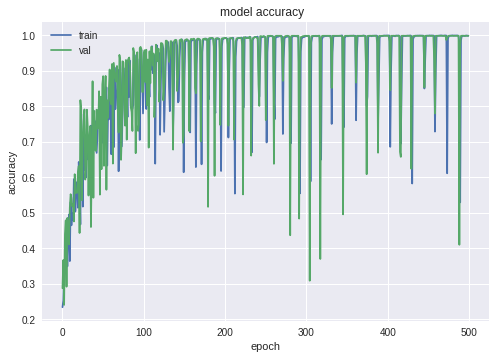

In [0]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'] )
plt.plot(history.history['val_categorical_accuracy'])
# plt.plot(history.history['val_acc'])
plt.title('model accuracy  ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

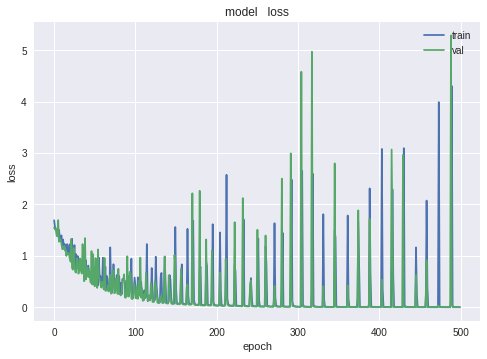

In [0]:
# summarize history for loss
plt.plot(history.history['loss'] )

plt.plot(history.history['val_loss'])
plt.title('model   loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()